In [ ]:

!sudo apt-get install tesseract-ocr -y
!pip install pytesseract



import os
import pandas as pd
import cv2
import torch
import numpy as np
from PIL import Image
import pytesseract
import tensorflow as tf
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer, ViTForImageClassification, ViTImageProcessor
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Set Tesseract path
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

# Load models and tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
text_model = TFRobertaForSequenceClassification.from_pretrained('/content/drive/My Drive/Colab Notebooks/private-data/models/roberta-cyberbullying-classifier')
vit_processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
vit_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', num_labels=4)
image_model_path = '/content/drive/My Drive/Colab Notebooks/private-data/models/best_vit_model.pth'
vit_model.load_state_dict(torch.load(image_model_path, map_location=torch.device('cpu')))

# Function to classify text
def classify_text(text):
    inputs = roberta_tokenizer.encode_plus(
        text, add_special_tokens=True, max_length=512,
        padding='max_length', truncation=True, return_tensors="tf"
    )
    roberta_prediction = text_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    roberta_probs = tf.nn.softmax(roberta_prediction.logits, axis=1)
    text_class = np.argmax(roberta_probs, axis=1)[0]
    return text_class

# Function to classify image
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = vit_processor(images=image, return_tensors="pt")['pixel_values']
    with torch.no_grad():
        outputs = vit_model(input_tensor)
        vit_probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        image_class = torch.argmax(vit_probs, dim=1).item()
    return image_class

def evaluate_text_data(text_csv_path):
    df_text = pd.read_csv(text_csv_path)
    df_text.dropna(subset=['text'], inplace=True)  # This line removes any rows with NaN in the 'text' column
    correct_predictions = 0
    total_samples = df_text.shape[0]
    for _, row in df_text.iterrows():
        text_pred = classify_text(row['text'])
        if text_pred == row['label']:
            correct_predictions += 1
    text_accuracy = correct_predictions / total_samples
    return text_accuracy


# Function to evaluate image data
def evaluate_image_data(image_folder_path):
    correct_predictions = 0
    total_samples = 0
    for class_id in os.listdir(image_folder_path):
        class_path = os.path.join(image_folder_path, class_id)
        for image_file in os.listdir(class_path):
            total_samples += 1
            image_path = os.path.join(class_path, image_file)
            image_pred = classify_image(image_path)
            if image_pred == int(class_id):
                correct_predictions += 1
    image_accuracy = correct_predictions / total_samples
    return image_accuracy

# Paths for the data loader
text_test_path = '/content/drive/My Drive/Colab Notebooks/private-data/text_data/test_data.csv'
image_test_path = '/content/drive/My Drive/Colab Notebooks/private-data/image/dataset/test'

# Calculate accuracies
text_accuracy = evaluate_text_data(text_test_path)
image_accuracy = evaluate_image_data(image_test_path)
average_accuracy = (text_accuracy + image_accuracy) / 2

# Output the results
print(f"Hybrid (RoBERTa + ViT) Model Average Accuracy: {average_accuracy}")


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,593 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at /content/drive/My Drive/Colab Notebooks/private-data/models/roberta-cyberbullying-classifier.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Hybrid (RoBERTa + ViT) Model Average Accuracy: 0.9601617511210625


In [ ]:
from sklearn.metrics import classification_report

def evaluate_text_data(text_csv_path):
    df_text = pd.read_csv(text_csv_path)
    df_text.dropna(subset=['text'], inplace=True)
    predictions = []
    true_labels = []
    for _, row in df_text.iterrows():
        text_pred = classify_text(row['text'])
        predictions.append(text_pred)
        true_labels.append(row['label'])
    metrics = classification_report(true_labels, predictions, output_dict=True)
    return metrics['accuracy'], metrics['macro avg']['precision'], metrics['macro avg']['recall'], metrics['macro avg']['f1-score']

def evaluate_image_data(image_folder_path):
    predictions = []
    true_labels = []
    for class_id in os.listdir(image_folder_path):
        class_path = os.path.join(image_folder_path, class_id)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image_pred = classify_image(image_path)
            predictions.append(image_pred)
            true_labels.append(int(class_id))
    metrics = classification_report(true_labels, predictions, output_dict=True)
    return metrics['accuracy'], metrics['macro avg']['precision'], metrics['macro avg']['recall'], metrics['macro avg']['f1-score']

# Calculate metrics
text_accuracy, text_precision, text_recall, text_f1 = evaluate_text_data(text_test_path)
image_accuracy, image_precision, image_recall, image_f1 = evaluate_image_data(image_test_path)
average_accuracy = (text_accuracy + image_accuracy) / 2
average_precision = (text_precision + image_precision) / 2
average_recall = (text_recall + image_recall) / 2
average_f1 = (text_f1 + image_f1) / 2

# Output the results
print(f"Hybrid (RoBERTa + ViT) Model Average Metrics:")
print(f"Accuracy: {average_accuracy}")
print(f"Precision: {average_precision}")
print(f"Recall: {average_recall}")
print(f"F1 Score: {average_f1}")


Hybrid (RoBERTa + ViT) Model Average Metrics:
Accuracy: 0.9601617511210625
Precision: 0.9604628844102878
Recall: 0.9598513895671732
F1 Score: 0.9598525144145669


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
from scipy import interp
from itertools import cycle
from torchvision.transforms import ToTensor

def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    input_tensor = vit_processor(images=image, return_tensors="pt")['pixel_values']
    with torch.no_grad():
        outputs = vit_model(input_tensor)
        vit_probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        image_class = torch.argmax(vit_probs, dim=1).item()
        return image_class, vit_probs.numpy()[0]  # Return class and probabilities as numpy array



def classify_text(text):
    inputs = roberta_tokenizer.encode_plus(
        text, add_special_tokens=True, max_length=512,
        padding='max_length', truncation=True, return_tensors="tf"
    )
    roberta_prediction = text_model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    roberta_probs = tf.nn.softmax(roberta_prediction.logits, axis=1).numpy()
    text_class = np.argmax(roberta_probs, axis=1)[0]
    return text_class, roberta_probs[0]  # Return both class and probabilities



def evaluate_text_data(text_csv_path):
    df_text = pd.read_csv(text_csv_path)
    df_text.dropna(subset=['text'], inplace=True)
    predictions = []
    true_labels = []
    probabilities = []  # Store probabilities for all classes
    for _, row in df_text.iterrows():
        text_class, text_probs = classify_text(row['text'])
        predictions.append(text_class)
        true_labels.append(row['label'])
        probabilities.append(text_probs)  # Assuming text_probs contains a list of probabilities
    metrics = classification_report(true_labels, predictions, output_dict=True)
    roc_auc = roc_auc_score(true_labels, probabilities, multi_class='ovr')
    conf_matrix = confusion_matrix(true_labels, predictions)
    return metrics['accuracy'], metrics['macro avg']['precision'], metrics['macro avg']['recall'], metrics['macro avg']['f1-score'], roc_auc, conf_matrix


def evaluate_image_data(image_folder_path):
    predictions = []
    true_labels = []
    probabilities = []  # To store probabilities for ROC AUC
    for class_id in os.listdir(image_folder_path):
        class_path = os.path.join(image_folder_path, class_id)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image_pred, image_probs = classify_image(image_path)
            predictions.append(image_pred)
            true_labels.append(int(class_id))
            probabilities.append(image_probs)  # Store probabilities
    metrics = classification_report(true_labels, predictions, output_dict=True)
    roc_auc = roc_auc_score(true_labels, probabilities, multi_class='ovr')
    conf_matrix = confusion_matrix(true_labels, predictions)
    return metrics['accuracy'], metrics['macro avg']['precision'], metrics['macro avg']['recall'], metrics['macro avg']['f1-score'], roc_auc, conf_matrix


# Calculate metrics
text_metrics = evaluate_text_data(text_test_path)
image_metrics = evaluate_image_data(image_test_path)

# Average calculations
average_accuracy = (text_metrics[0] + image_metrics[0]) / 2
average_precision = (text_metrics[1] + image_metrics[1]) / 2
average_recall = (text_metrics[2] + image_metrics[2]) / 2
average_f1 = (text_metrics[3] + image_metrics[3]) / 2
average_roc_auc = (text_metrics[4] + image_metrics[4]) / 2

# Output the results
print(f"Hybrid (RoBERTa + ViT) Model Average Metrics:")
print(f"Accuracy: {average_accuracy}")
print(f"Precision: {average_precision}")
print(f"Recall: {average_recall}")
print(f"F1 Score: {average_f1}")
print(f"Average ROC AUC: {average_roc_auc}")


Hybrid (RoBERTa + ViT) Model Average Metrics:
Accuracy: 0.9601617511210625
Precision: 0.9604628844102878
Recall: 0.9598513895671732
F1 Score: 0.9598525144145669
Average ROC AUC: 0.9956888395584444


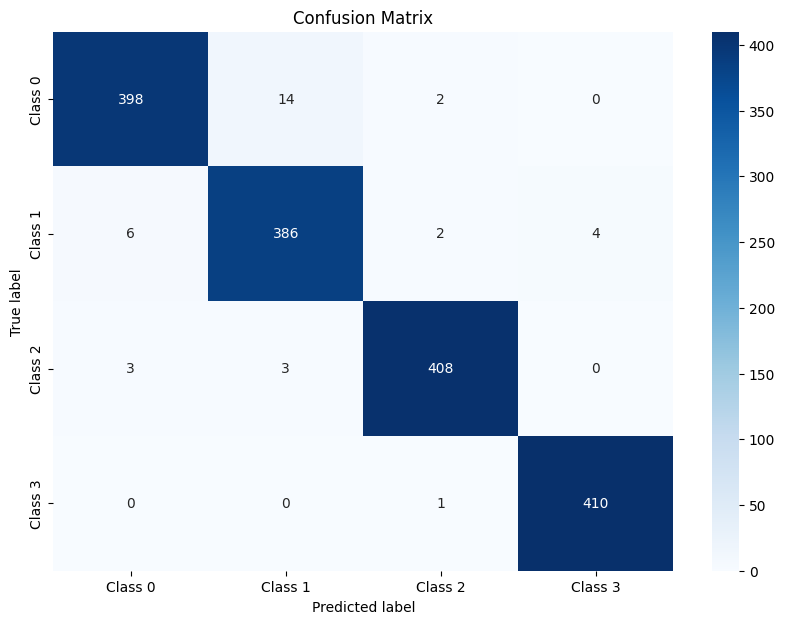

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
from scipy import interp
from numpy import mean


def plot_roc_curve(true_labels, probabilities):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(true_labels, probabilities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return roc_auc

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()



average_conf_matrix = (text_metrics[5] + image_metrics[5]) / 2
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

plot_confusion_matrix(average_conf_matrix, class_names)


